In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download rishianand/devanagari-character-set

Dataset URL: https://www.kaggle.com/datasets/rishianand/devanagari-character-set
License(s): CC0-1.0
  0% 0.00/118M [00:00<?, ?B/s]
100% 118M/118M [00:00<00:00, 1.66GB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/devanagari-character-set.zip",'r')
zip.extractall("/content")
zip.close()

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from data_loader import DataLoader
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
loader = DataLoader(data_dir="/content/Images/Images", img_size=(32,32))

X_train, X_val, X_test, y_train, y_val, y_test, classes = loader.load_data()

X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

Classes Found: ['character_01_ka', 'character_02_kha', 'character_03_ga', 'character_04_gha', 'character_05_kna', 'character_06_cha', 'character_07_chha', 'character_08_ja', 'character_09_jha', 'character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']
character_01_ka: 2000 files is loaded
character_02_kha: 2000 files is loaded
character_03_ga: 2000 files is loaded
character_04_gha:

In [7]:
X_train.shape, y_train.shape

((73600, 32, 32, 3), (73600,))

In [8]:
num_classes = len(classes.classes_)

In [9]:
base_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape=(32,32,3)
)

/tmp/ipython-input-3414908077.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [11]:
model = models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │        11,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,598,766 (9.91 MB)

 Trainable params: 2,564,142 (9.78 MB)

 Non-trainable params: 34,624 (135.25 KB)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience= 5,
    restore_best_weights = True
)

checkpoint = ModelCheckpoint(
    filepath='mobilenetv2_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose =1
)

In [15]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/50
2298/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5946 - loss: 1.5244
Epoch 1: val_accuracy improved from -inf to 0.69978, saving model to mobilenetv2_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 100s 22ms/step - accuracy: 0.5948 - loss: 1.5235 - val_accuracy: 0.6998 - val_loss: 1.4004
Epoch 2/50
2297/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9069 - loss: 0.3309
Epoch 2: val_accuracy improved from 0.69978 to 0.86728, saving model to mobilenetv2_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9069 - loss: 0.3309 - val_accuracy: 0.8673 - val_loss: 0.5415
Epoch 3/50
2296/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9317 - loss: 0.2407
Epoch 3: val_accuracy improved from 0.86728 to 0.91054, saving model to mobilenetv2_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9317 - loss: 0.2406 - val_accuracy: 0.9105 - val_loss: 0.3789
Epoch 4/50
2298/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9464 - loss: 0.185

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9859 - loss: 0.0616
Test Accuracy: 98.57%


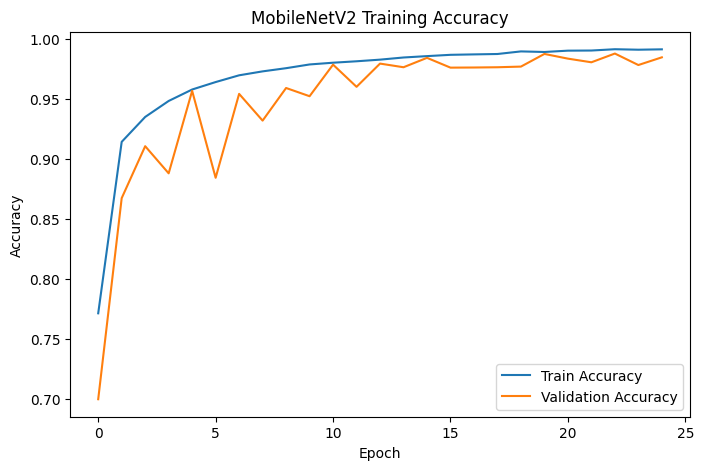

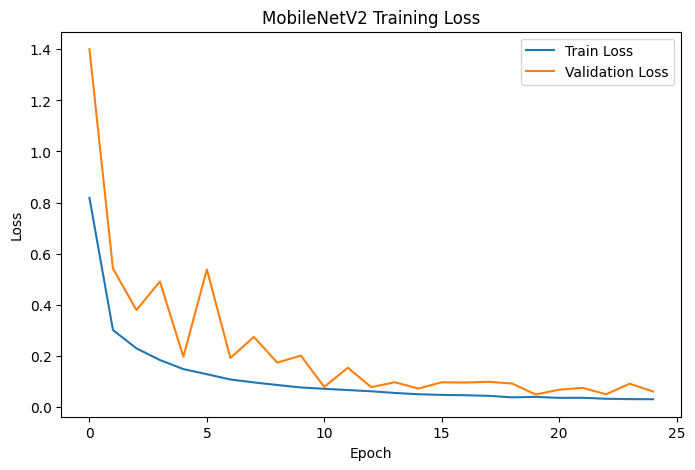

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
fine_tune_at = 40
for layer in base_model.layers[-fine_tune_at:]:
    layer.trainable = True

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint_finetune = ModelCheckpoint(
    filepath='mobilenetv2_finetuned_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [21]:
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint_finetune],
    verbose=1
)

Epoch 1/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9955 - loss: 0.0152
Epoch 1: val_accuracy improved from -inf to 0.99457, saving model to mobilenetv2_finetuned_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - accuracy: 0.9955 - loss: 0.0152 - val_accuracy: 0.9946 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 2/50
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9974 - loss: 0.0090
Epoch 2: val_accuracy did not improve from 0.99457
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9974 - loss: 0.0090 - val_accuracy: 0.9940 - val_loss: 0.0224 - learning_rate: 1.0000e-04
Epoch 3/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9983 - loss: 0.0056
Epoch 3: val_accuracy did not improve from 0.99457
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9942 - val_loss: 0.0227 - learning_rate: 1.0000e-04
Epoch 4/50
2296/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9988 - loss: 

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9925 - loss: 0.0355
Test Accuracy: 99.24%


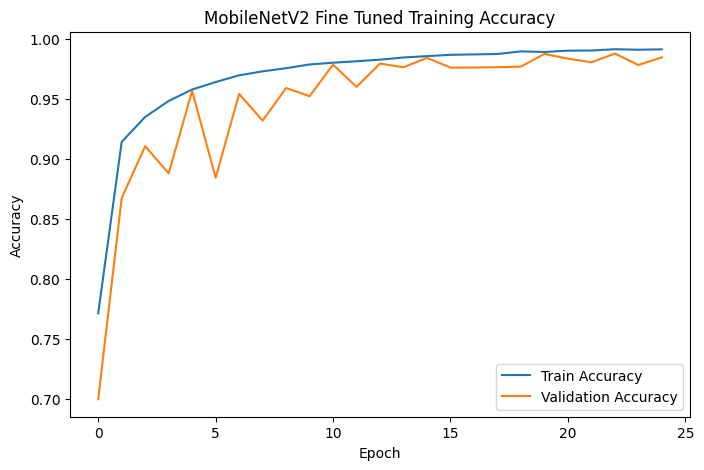

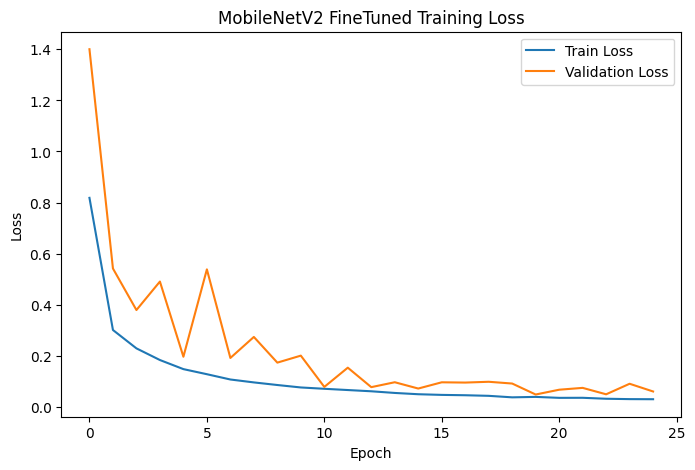

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Fine Tuned Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 FineTuned Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
from sklearn.metrics import confusion_matrix

In [ ]:
test_prediction = model.predict(X_test)

